# Saliencies for CondVAE model

Compute saliencies to understand what channels the model is focussing on for a specific channel.
Calculate saliency of output wrt latent + condition. This essentially calculates saliencies for the decoder to the decoder input. 

Procedure:
- Calculate integrated gradients [(Sundararajan, 2017)](https://arxiv.org/abs/1703.01365) for `aggregated/sub-0.001` dataset of `CondVAE_pert-CC`
- Use mean latent space of unperturbed Nucleoplasm pixels as baseline for latent. Use zeros as baseline for condition. 
- Calculate condition importance as fraction of absolute gradients going towards condition input.
- Plot 1: median condition importance per channel and perturbation
- Plot 2: median condition importance vs overall intensity changes per channel and perturbation

In [1]:
from campa.constants import campa_config
from campa.tl import Experiment, Predictor, Cluster
from campa_ana.constants import SOURCE_DIR
from campa.data import MPPData
import os
from campa.tl._cluster import annotate_clustering
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from adjustText import adjust_text
import anndata as ad
import pickle

fig_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(str(fig_dir), exist_ok=True)

Reading config from /home/theislab/l_spitzer/.config/campa/campa.ini


## Load data

In [2]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
pred = Predictor(exp)
mpp_data = MPPData.from_data_dir('aggregated/sub-0.001', data_config='NascentRNA', base_dir=exp.full_path, keys=['latent', 'conditions', 'clustering_res0.5'])
cluster_annotation = pd.read_csv(os.path.join(exp.full_path, 'aggregated/sub-0.001/clustering_res0.5_annotation.csv'), index_col=0)
# add annotation of clustering to mpp_data
mpp_data._data['annotation'] = annotate_clustering(list(map(int, mpp_data.data('clustering_res0.5'))), annotation=cluster_annotation, cluster_name='clustering_res0.5', annotation_col='annotation')

## Calculate integrated_gradients

Run `python calculate_saliency.py` (setting `use_model='decoder'` in the code)

## Load calculated gradients

In [3]:
channels = list(mpp_data.channels.name)

norm_grads = {}
for pert in  ['unperturbed', 'AZD4573-30', 'TSA-30', 'CX5461-120', 'AZD4573-120', 'Triptolide-120', 'Meayamycin-720']:
    # load
    if pert == 'unperturbed':
        fname = 'saliency_output_latent_normal_DMSO-720_DMSO-120.pkl'
    else:
        fname = f'saliency_output_latent_{pert}.pkl'
    grads_mpp, grads_condition = pickle.load(open(fig_dir / fname, "rb"))
    # grads per output x sample x input
    # concatenate grads_condition to the end of input
    grads_overall = np.concatenate([np.abs(grads_mpp), np.abs(grads_condition).sum(axis=-1)], axis=-1)

    # calculate relative importance of input per output channel
    total_grads = grads_overall.sum(axis=-1, keepdims=True)
    norm_grads[pert] = grads_overall / total_grads
    


## Plot importance of each input channel for output channels (also importance of condition)

### Explore plots (summary barplots)

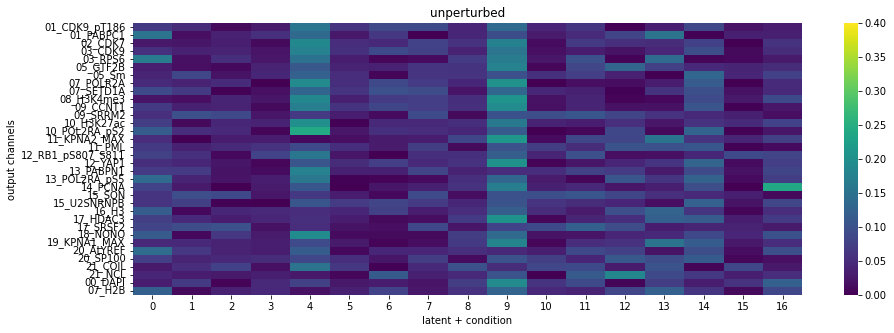

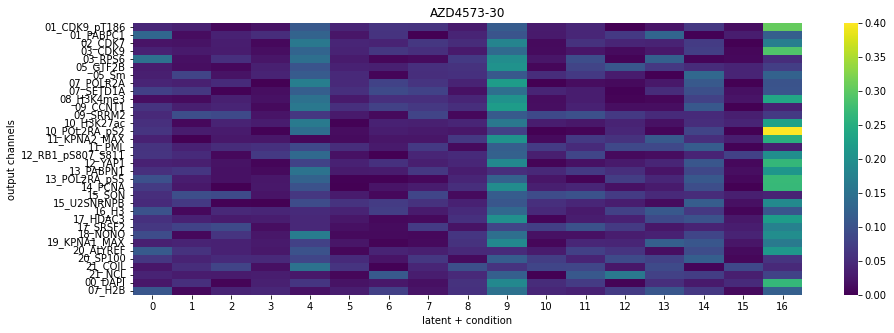

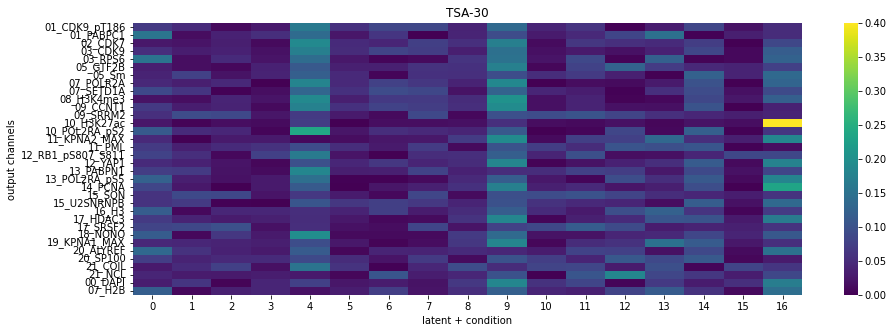

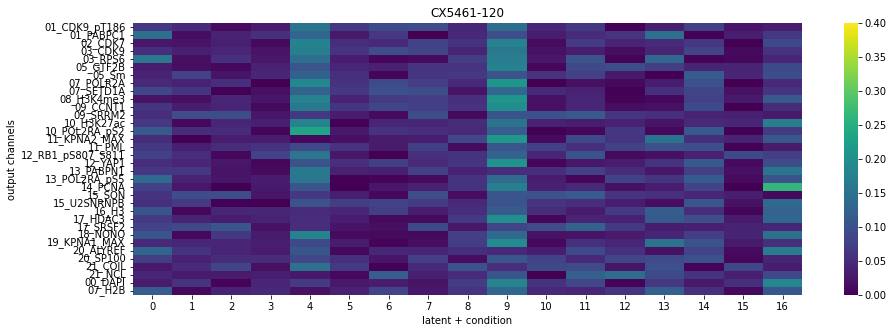

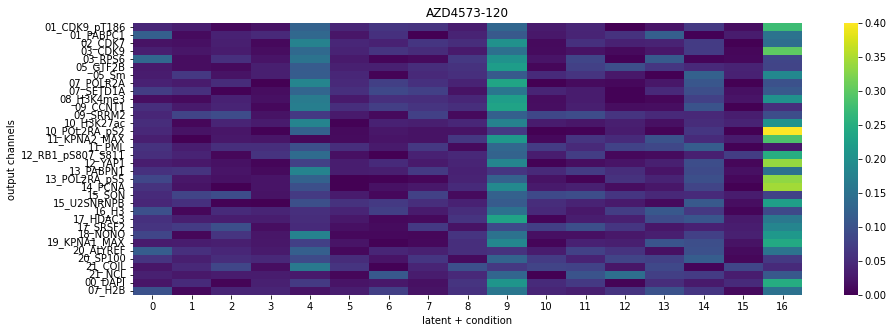

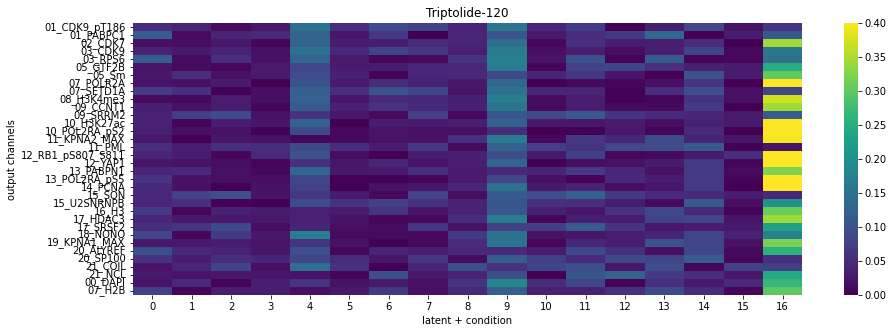

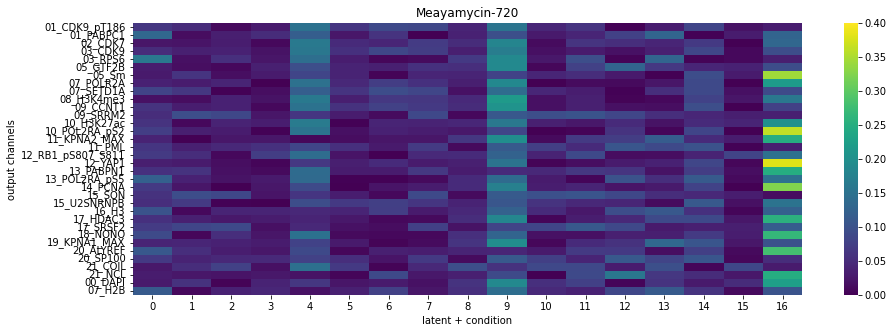

In [4]:
# detailled view of importance of input for each output channel.
# scores are percent of gradients going to input channel / condition. Values are mean abs gradients.
for pert in norm_grads.keys():
    mean_norm_grads = norm_grads[pert].mean(axis=0)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    sns.heatmap(mean_norm_grads,
                yticklabels=channels, cmap='viridis', vmin=0, vmax=0.4, ax=ax)
    ax.set_ylabel('output channels')
    ax.set_xlabel('latent + condition')
    ax.set_title(pert)

### Boxplots

In [5]:
# boxplot of condition importances

# mapping to rename channels to pretty names (from Scott)
channel_rename_dict = {'new': {'01_PABPC1': 'PABPC1', '02_CDK7': 'CDK7', '03_RPS6': 'RPS6', '04_SUPT5H': 'SUPT5H', '05_Sm': 'Sm', '06_CTNNB1': 'CTNNB1', '07_POLR2A': 'POLR2A', '08_PXN': 'PXN', '09_CCNT1': 'CCNT1', '10_POL2RA_pS2': 'POLR2A-S2P', '11_PML': 'PML', '12_YAP1': 'YAP1', '13_POL2RA_pS5': 'POLR2A-S5P', '14_HSPD1': 'HSPD1', '15_U2SNRNPB': 'U2SNRNPB', '16_GOLGA2': 'GOLGA2', '17_SRSF2': 'SRSF2', '18_NONO': 'NONO', '19_TUBA1A': 'TUBA1A', '20_ALYREF': 'ALYREF', '21_COIL': 'COIL', '22_NPM1': 'NPM1', '00_BG488': 'BG488', '01_CDK9_pT186': 'pCDK9', '02_RPS6_pS235_S236': 'pRPS6', '03_CDK9': 'CDK9', '04_MAPK1_pT202_T204': 'pMAPK1', '05_GTF2B': 'GTF2B', '06_CALR': 'CALR', '07_SETD1A': 'SETD1A', '08_H3K4me3': 'H3K4me3', '09_SRRM2': 'SRRM2', '10_H3K27ac': 'H3K27ac', '11_KPNA2_MAX': 'KPNA2', '11_KPNA2_SUM': 'KPNA2 (SUM)', '12_RB1_pS807_S811': 'pRB1', '13_PABPN1': 'PABPN1', '14_PCNA': 'PCNA', '15_SON': 'SON', '16_H3': 'H3', '17_HDAC3': 'HDAC3', '18_FBL': 'FBL', '19_KPNA1_MAX': 'KPNA1', '19_KPNA1_SUM': 'KPNA1 (SUM)', '20_SP100': 'SP100', '21_NCL': 'NCL', '22_DDX6': 'DDX6', '00_BG568': 'BG568', '00_DAPI': 'DAPI', '07_H2B': 'H2B', '00_EU': 'EU', '22_SE': 'SE'}}
channel_rename = pd.DataFrame(channel_rename_dict)

channel_names = np.array((channel_rename.loc[mpp_data.channels.name].new))

<ipython-input-6-c4aebdb1b2fa>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15,7))


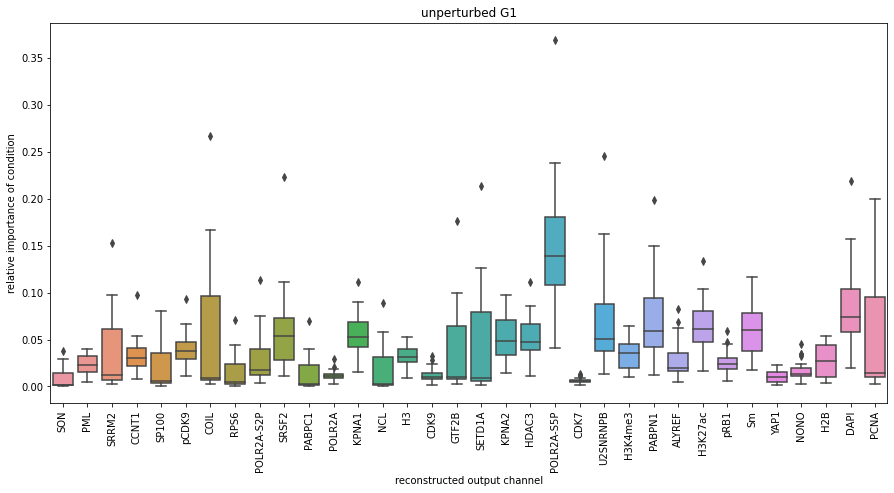

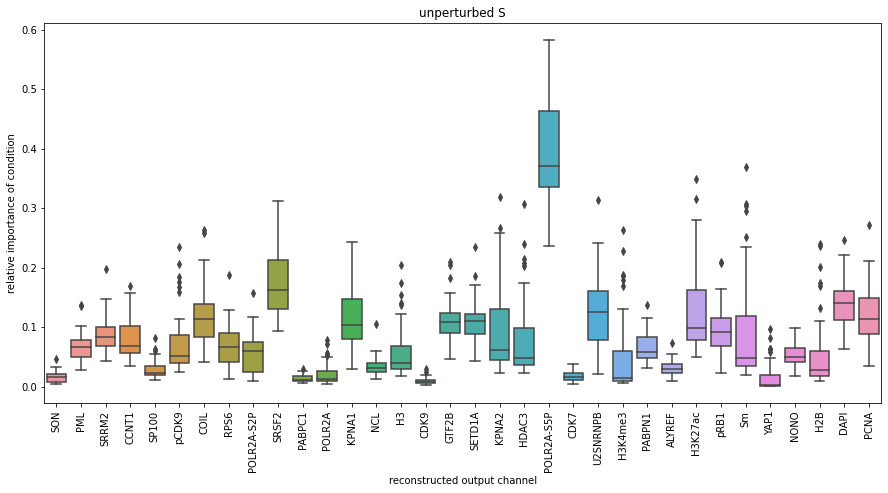

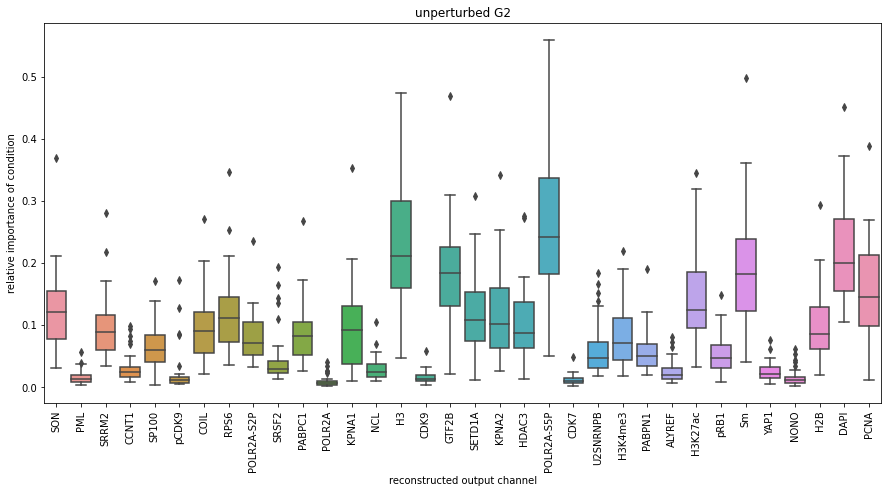

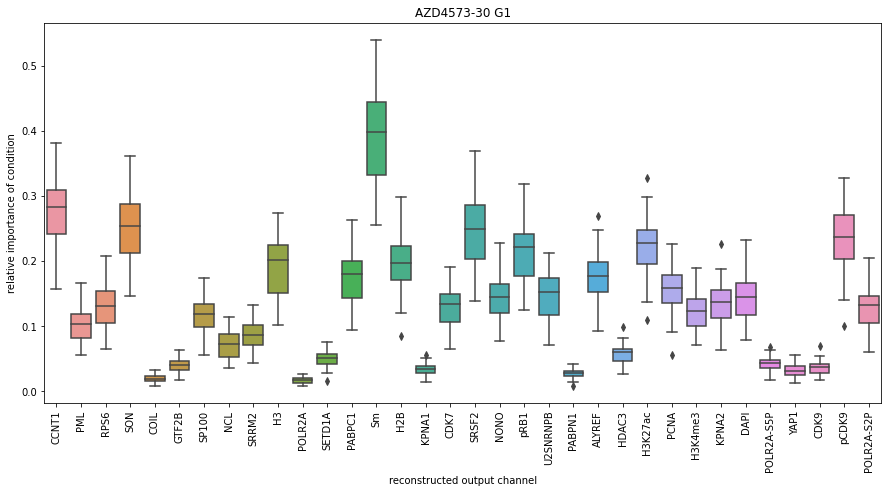

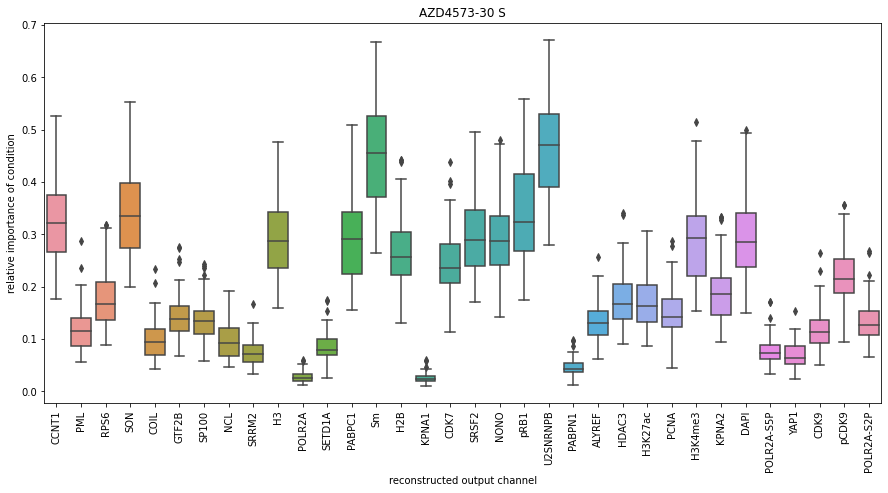

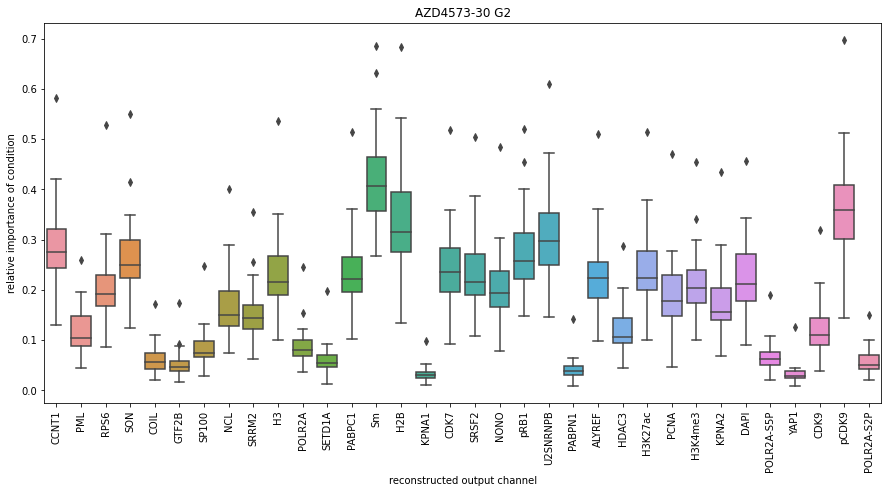

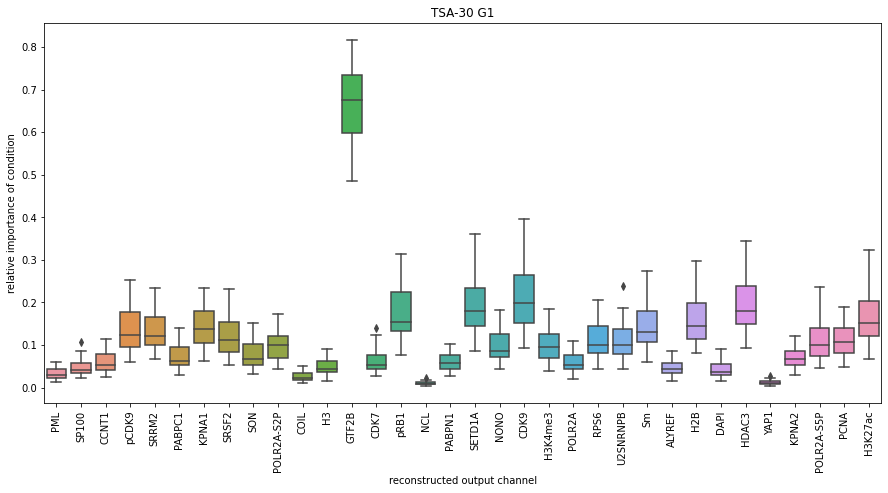

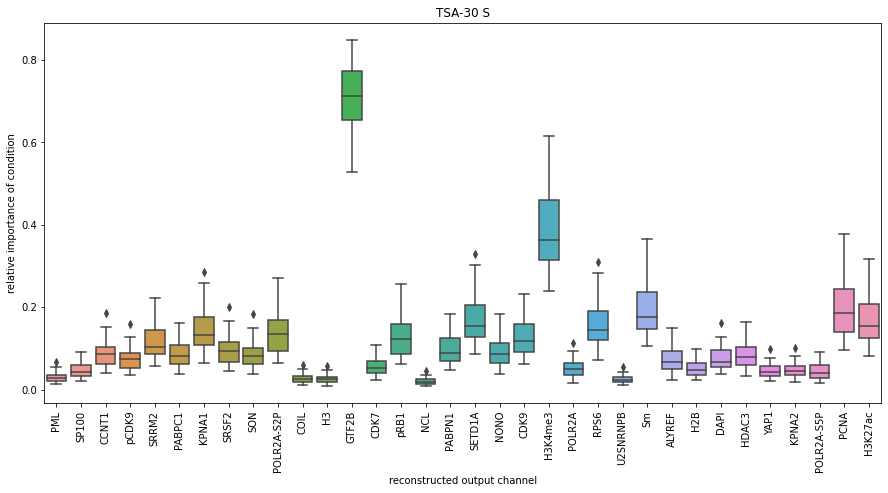

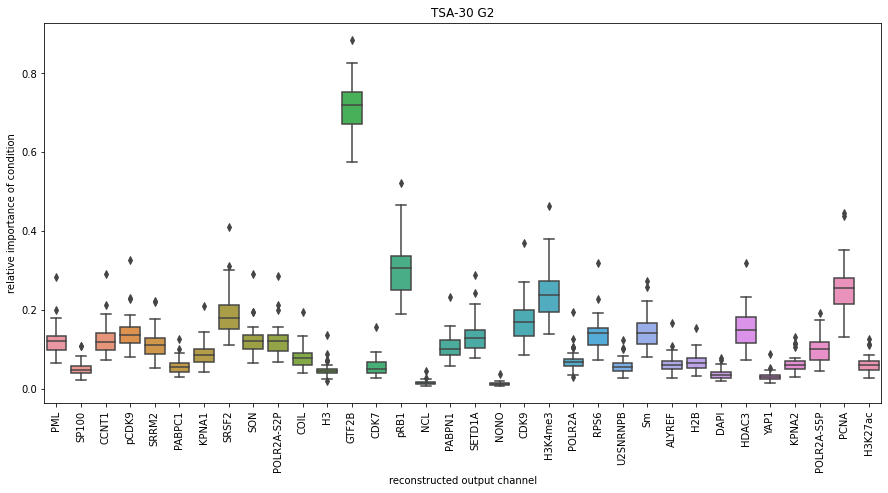

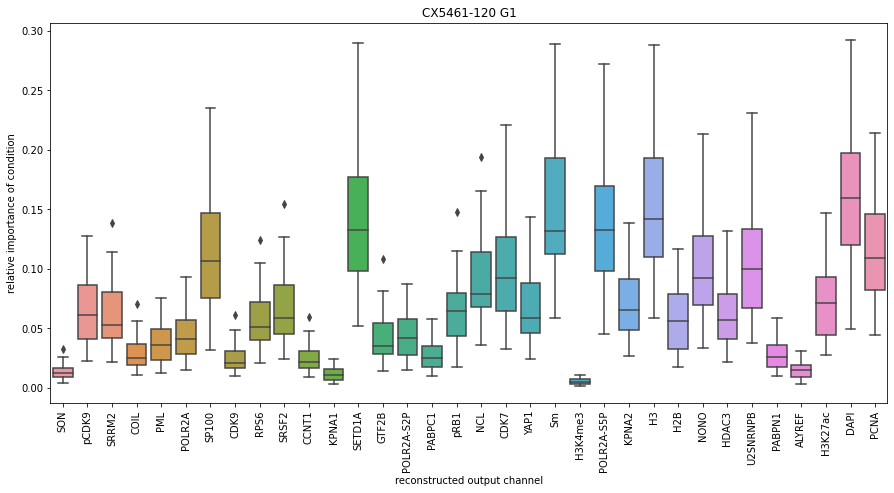

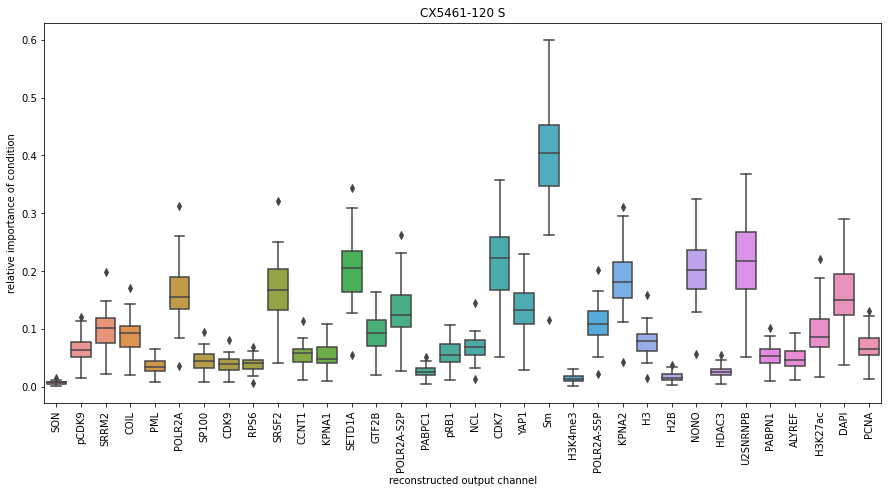

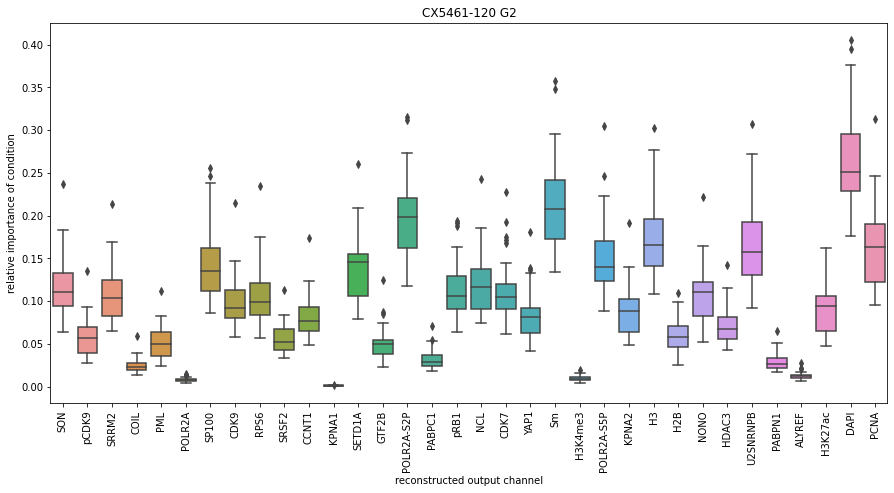

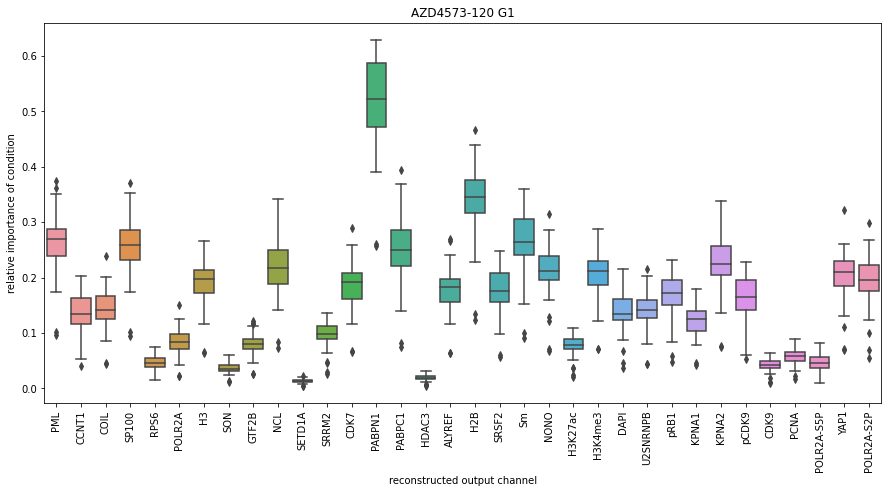

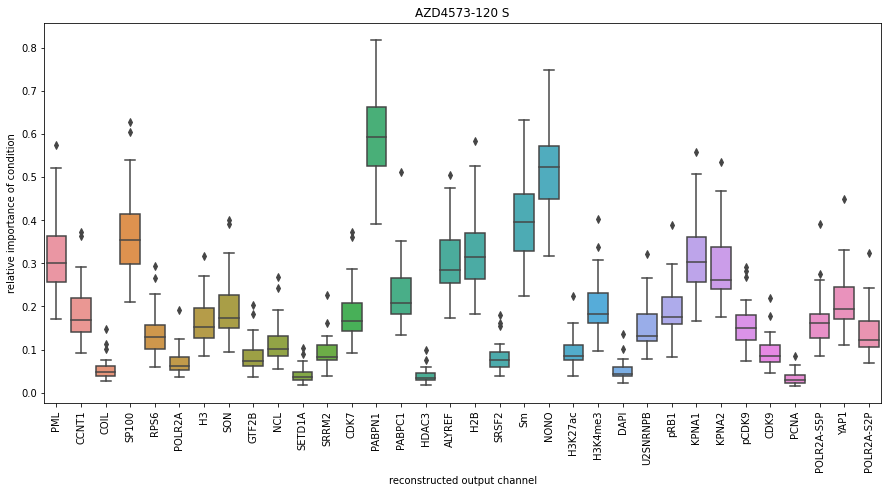

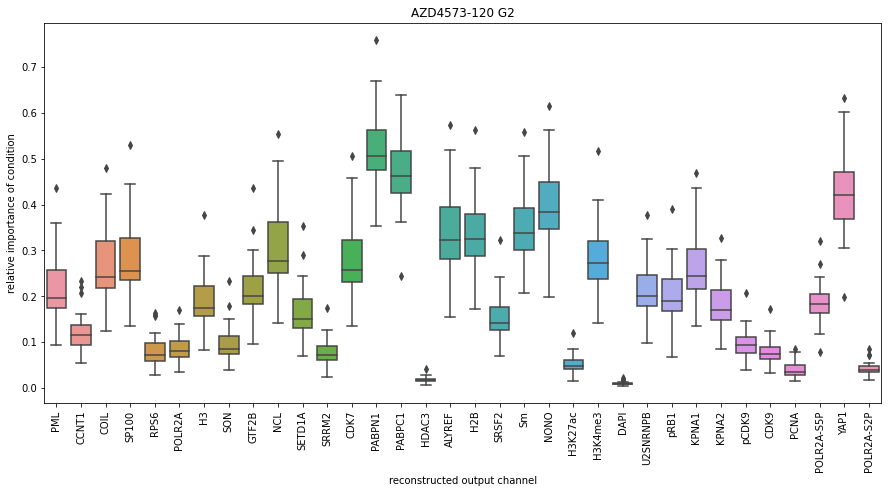

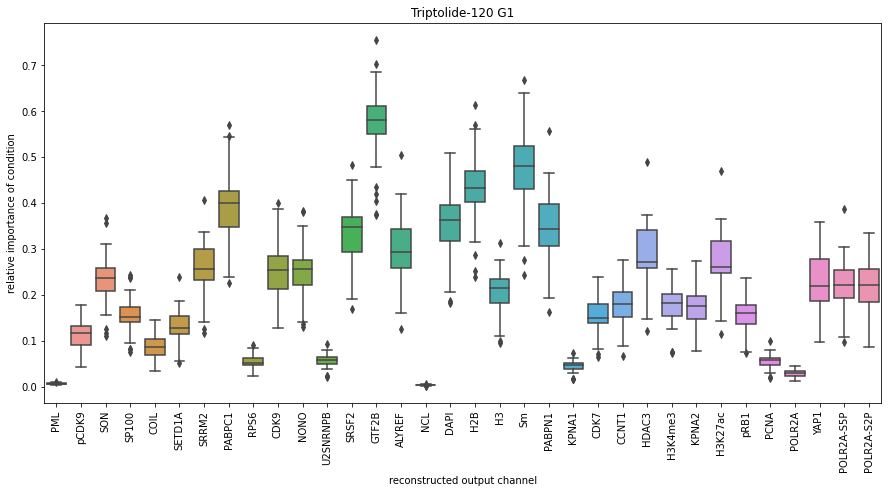

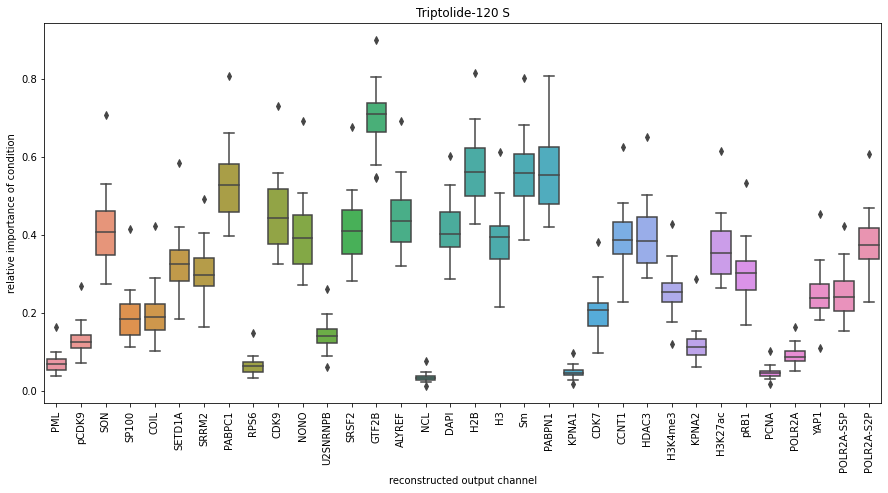

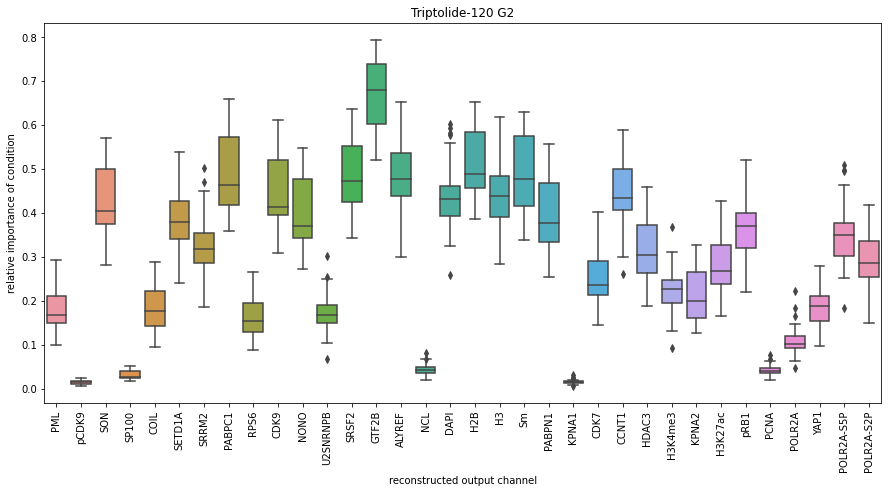

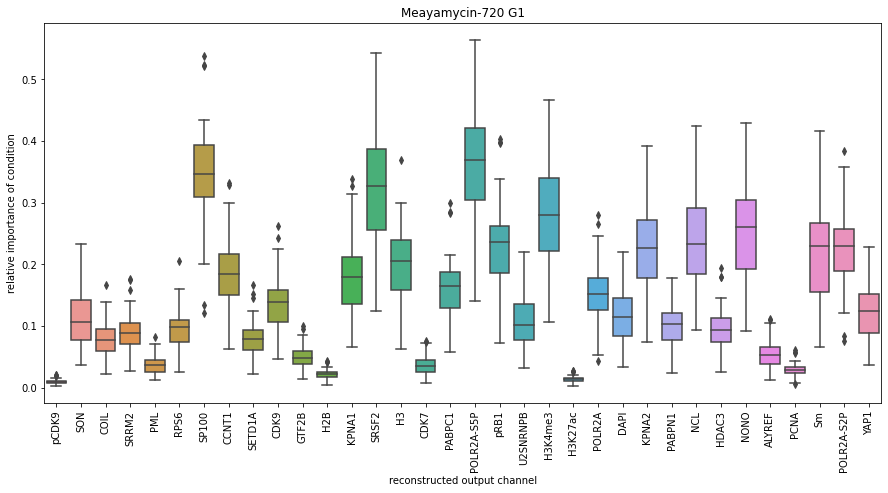

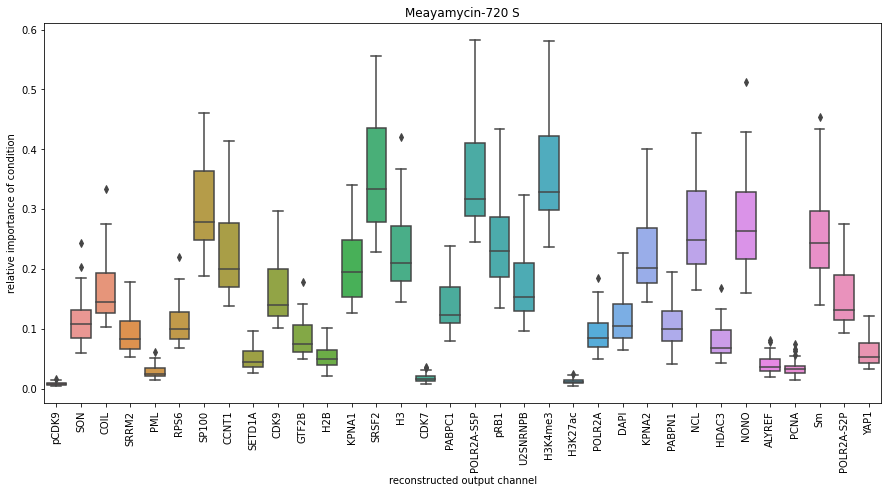

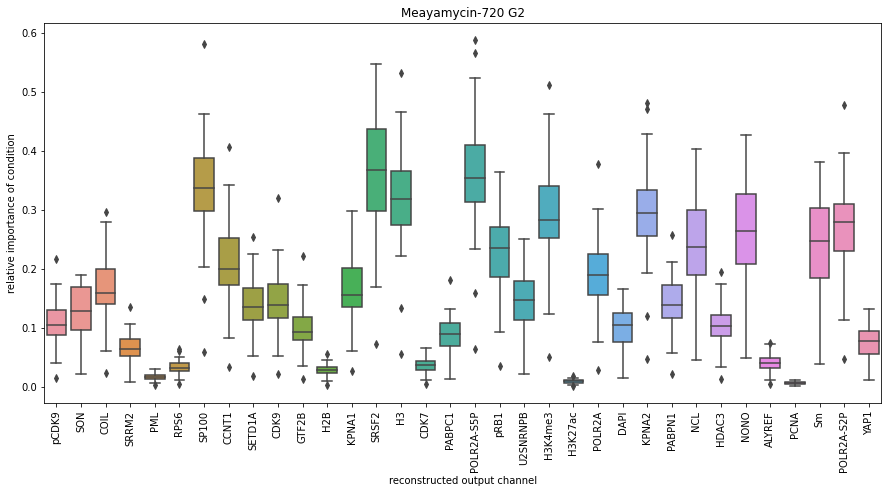

In [6]:
# pert split up by cell cycle

for pert in norm_grads.keys():
    if pert == 'unperturbed':
        perts = ['normal', 'DMSO-720', 'DMSO-120']
    else:
        perts = [pert]
    # define order on median overall
    norm_grads_cond = norm_grads[pert][:,:,16]
    order = np.argsort(np.median(norm_grads_cond, axis=0))

    mpp_mask = mpp_data._get_per_mpp_value(mpp_data.metadata['perturbation_duration'].isin(perts))
    sub_mpp = mpp_data.apply_mask(mpp_mask, copy=True)
    for cc in ['G1', 'S', 'G2']:
        sub_mask = sub_mpp._get_per_mpp_value(sub_mpp.metadata['cell_cycle'] == cc)
        # plot values per pert and cell cycle
        fig, ax = plt.subplots(figsize=(15,7))
        sns.boxplot(data=norm_grads_cond[sub_mask][order], ax=ax)
        _ = ax.set_xticklabels(channel_names[order], rotation=90)
        ax.set_ylabel('relative importance of condition')
        ax.set_xlabel('reconstructed output channel')
        ax.set_title(f'{pert} {cc}')

## Plot grads and logfc in one plot

In [7]:
# get log2fc of channels in overall data
from campa.tl import Experiment, FeatureExtractor
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
features_fname = 'features_annotation.h5ad'

# load extracted features for clustering_res0.5, annotation
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, features_fname)) for data_dir in exp.data_params['data_dirs']]

# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')

In [8]:
# calculate logfc of channel intensity in different conditions
mean_ref = adata[adata.obs['perturbation_duration'].isin(['normal', 'DMSO-720', 'DMSO-120'])].X.mean(axis=0)

logfc = []
gs = []
cs = []

# add corrent perturbation label
p = {'AZD4573-120': 'AZD4573 (2.5h)', 
    'AZD4573-30': 'AZD4573 (1h)',
    'CX5461-120':'CX5461 (2.5h)',
    'Meayamycin-720':'Meayamycin (12.5h)',
    'TSA-30':'TSA (1h)',
    'Triptolide-120':'Triptolide (2.5h)',
     'unperturbed':'unperturbed'}

# perturbations & cell cycle
mean_ref = adata[adata.obs['perturbation_duration'].isin(['normal', 'DMSO-720', 'DMSO-120']) & (adata.obs['cell_cycle']=='G1')].X.mean(axis=0)
for g in ['AZD4573-30', 'TSA-30', 'CX5461-120', 'AZD4573-120', 'Triptolide-120', 'Meayamycin-720', 'unperturbed']:
    if g == 'unperturbed':
        perts = ['normal', 'DMSO-720', 'DMSO-120']
    else:
        perts = [g]
    for c in ['G1', 'S', 'G2']:
        mean_g = adata[(adata.obs['perturbation_duration'].isin(perts)) & (adata.obs['cell_cycle']==c)].X.mean(axis=0)
        logfc.append(np.log2(mean_g / mean_ref))
        gs.append(p[g])
        cs.append(c)
    
logfc = np.array(logfc)
logfc = pd.DataFrame(logfc, columns=channel_names)
logfc['perturbation'] = gs
logfc['cell_cycle'] = cs

In [9]:
# build one df for norm_grads
norm_grads_df = {}
for pert in norm_grads.keys():
    norm_grads_df[pert] = pd.DataFrame(norm_grads[pert][:,:,16], columns=channel_names)
    # get cell cycle value
    if pert == 'unperturbed':
        perts = ['normal', 'DMSO-720', 'DMSO-120']
    else:
        perts = [pert]
    mpp_mask = mpp_data._get_per_mpp_value(mpp_data.metadata['perturbation_duration'].isin(perts))
    sub_mpp = mpp_data.apply_mask(mpp_mask, copy=True)
    cc = sub_mpp._get_per_mpp_value(sub_mpp.metadata['cell_cycle'])
    norm_grads_df[pert]['cell_cycle'] = cc
norm_grads_df = pd.concat(norm_grads_df).reset_index(level=0, names='perturbation')
norm_grads_df = pd.melt(norm_grads_df, id_vars=['perturbation', 'cell_cycle'], var_name='channel', value_name='saliency')

### distribution of saliency values across perturbation

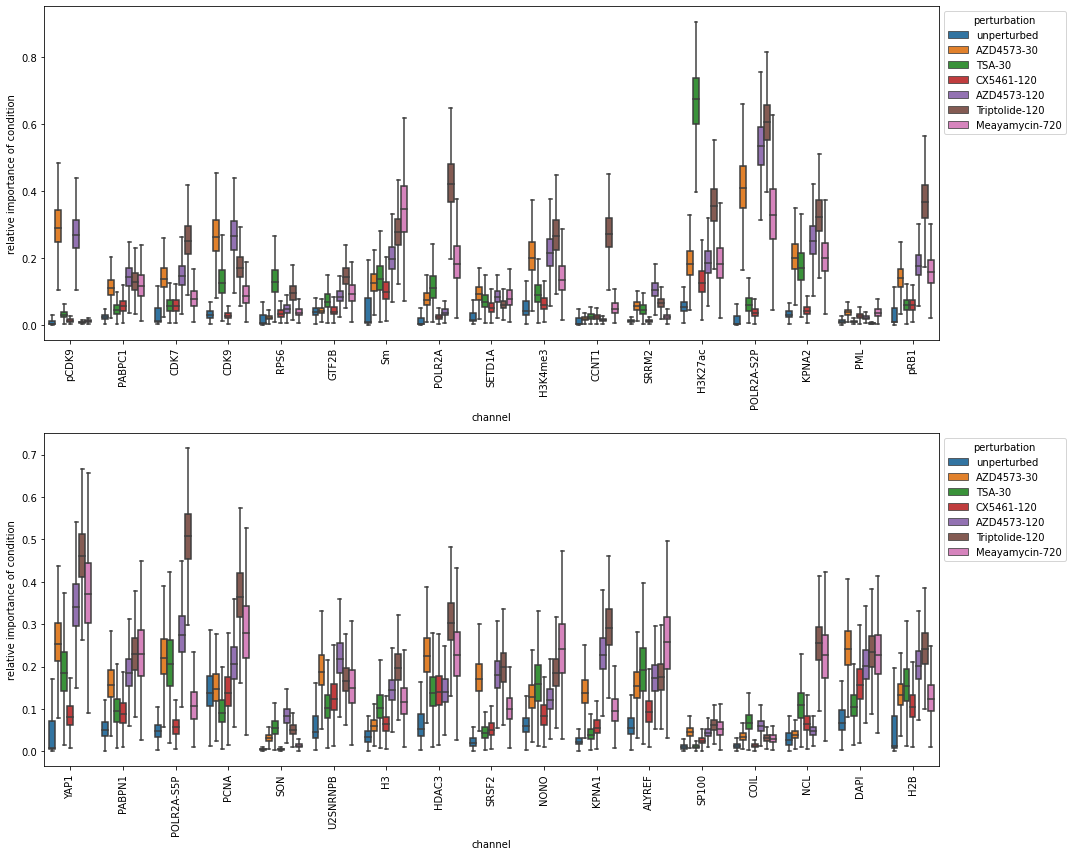

In [10]:
# nice plot for distribution of saliency values (only G1 cells)

fig, axes = plt.subplots(2,1, figsize=(15,12))
sns.boxplot(norm_grads_df[(norm_grads_df['cell_cycle']=='G1') & norm_grads_df['channel'].isin(channel_names[:17])], 
            x='channel', y='saliency', hue='perturbation', ax=axes[0], showfliers = False)
_ = axes[0].set_xticklabels(channel_names[:17], rotation=90)
axes[0].set_ylabel('relative importance of condition')

sns.boxplot(norm_grads_df[(norm_grads_df['cell_cycle']=='G1') & norm_grads_df['channel'].isin(channel_names[17:])], 
            x='channel', y='saliency', hue='perturbation', ax=axes[1], showfliers = False)
g = axes[1].set_xticklabels(channel_names[17:], rotation=90)
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))
axes[1].set_ylabel('relative importance of condition')
plt.tight_layout()

plt.savefig(fig_dir / 'saliency_per_perturbation_latent.png', bbox_inches='tight', dpi=300)

# heatmap of logfc 
#fig, ax = plt.subplots(1,1, figsize=(15,5))
#sns.heatmap(logfc[logfc['cell_cycle'] == 'G1'].set_index('perturbation')[channel_names], vmin=-2, vmax=2,
#           xticklabels=True, yticklabels=True, ax=ax)



### same plot for cell cycle

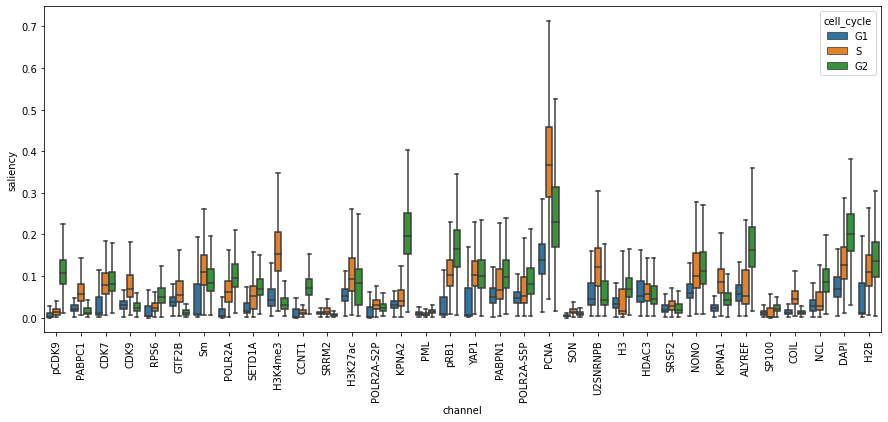

In [11]:
# cell cycle
fig, ax = plt.subplots(figsize=(15,6))
# TODO after recalcuation of saliency, maybe use only unperturbed here
sns.boxplot(norm_grads_df[norm_grads_df['perturbation']=='unperturbed'], x='channel', y='saliency', hue='cell_cycle', ax=ax, showfliers = False)
_ = ax.set_xticklabels(channel_names, rotation=90)
plt.savefig(fig_dir / 'saliency_per_cellcycle_latent.png', bbox_inches='tight', dpi=300)

#fig, ax = plt.subplots(1,1, figsize=(15,5))
#sns.heatmap(logfc[logfc['perturbation'] == 'unperturbed'].set_index('cell_cycle')[channel_names], vmin=-1, vmax=1,
#           xticklabels=True, yticklabels=True, ax=ax)

### Suppl plot 1: plot summary of median values per perturbation and cell cycle

In [12]:
# plot clustermap of norm_grads per perturbation (only G1 cells)
median_grads_wide = norm_grads_df[norm_grads_df['cell_cycle']=='G1'].groupby(['perturbation','channel']).median().reset_index().pivot(index='perturbation', columns='channel', values='saliency')
# alternative: plot logfc_grads
logfc_grads = np.log2(median_grads_wide / median_grads_wide.loc['unperturbed'])

median_grads_wide_cc = norm_grads_df[norm_grads_df['perturbation']=='unperturbed'].groupby(['cell_cycle', 'channel']).median().reset_index().pivot(index='cell_cycle', columns='channel', values='saliency')


<ipython-input-12-318d513ffb31>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_grads_wide = norm_grads_df[norm_grads_df['cell_cycle']=='G1'].groupby(['perturbation','channel']).median().reset_index().pivot(index='perturbation', columns='channel', values='saliency')
<ipython-input-12-318d513ffb31>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_grads_wide_cc = norm_grads_df[norm_grads_df['perturbation']=='unperturbed'].groupby(['cell_cycle', 'channel']).median().reset_index().pivot(index='cell_cycle', columns='channel', values='saliency')


In [13]:
# add corrent perturbation label
p = {'AZD4573-120': 'AZD4573 (2.5h)', 
    'AZD4573-30': 'AZD4573 (1h)',
    'CX5461-120':'CX5461 (2.5h)',
    'Meayamycin-720':'Meayamycin (12.5h)',
    'TSA-30':'TSA (1h)',
    'Triptolide-120':'Triptolide (2.5h)',
     'unperturbed':'unperturbed'}
median_grads_wide['perturbation_clean'] = pd.DataFrame(p, index=['perturbation_clean']).T
median_grads_wide = median_grads_wide.set_index('perturbation_clean')
median_grads_wide.index = median_grads_wide.index.rename('perturbation')

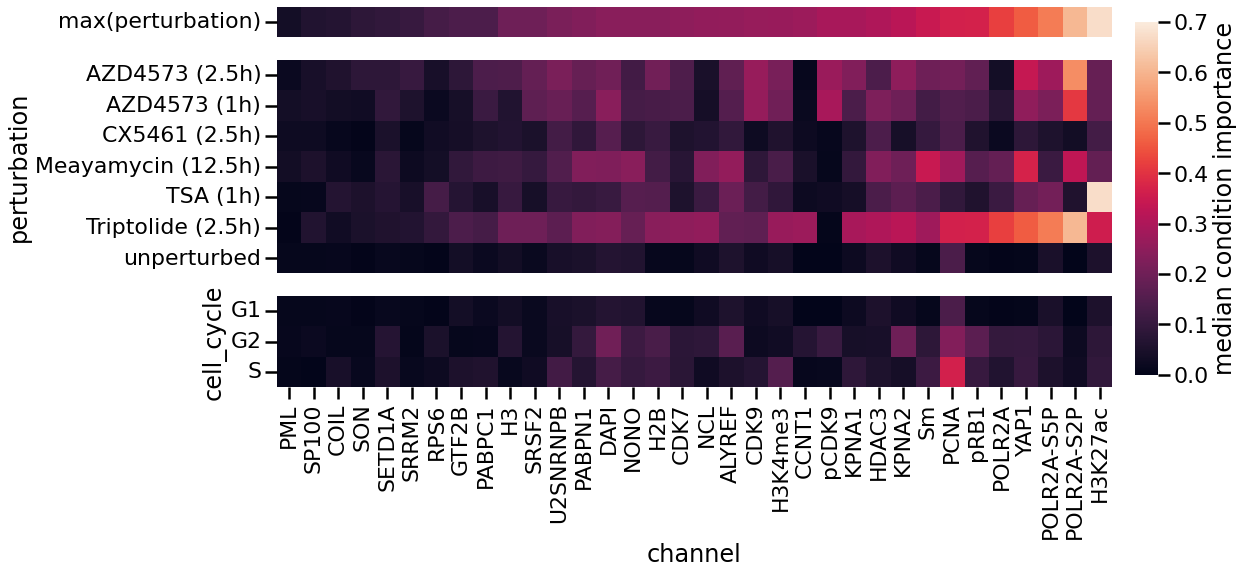

In [15]:
sns.set_context('poster')

column_order = median_grads_wide.columns[np.argsort(median_grads_wide.max(axis=0))]

fig, axes = plt.subplots(3,1, figsize=(16,7), sharex=True, height_ratios=[1,7,3])
# make space for cbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])

df = pd.DataFrame(median_grads_wide[column_order].max()).rename(columns={0: 'max(perturbation)'})
# max importance
g = sns.heatmap(df.T, ax=axes[0], vmin=0, vmax=0.7, cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
axes[0].set_xlabel('')
g.tick_params(bottom=False)
# importance per perturbation
g = sns.heatmap(median_grads_wide[column_order], xticklabels=True, yticklabels=True, ax=axes[1], vmin=0, vmax=0.7, cbar=False)
axes[1].set_xlabel('')
g.tick_params(bottom=False)
# impotance per cell cycle
g = sns.heatmap(median_grads_wide_cc[column_order], xticklabels=True, yticklabels=True, ax=axes[2], vmin=0, vmax=0.7, cbar_ax=cbar_ax,
               cbar_kws={'label': 'median condition importance'})

plt.savefig(fig_dir / 'saliency_perturbation_cc_heatmap_latent.pdf', dpi=300, bbox_inches='tight')

In [122]:
#cg = sns.clustermap(median_grads_wide, xticklabels=True, yticklabels=True, figsize=(15,5))

#row_order = median_grads_wide.index[cg.dendrogram_row.reordered_ind]
#col_order = median_grads_wide.columns[cg.dendrogram_col.reordered_ind]

#fig, ax = plt.subplots(1,1, figsize=(15,5))
#sns.heatmap(logfc[logfc['cell_cycle'] == 'G1'].set_index('perturbation').loc[row_order][col_order], cmap='bwr', vmin=-2, vmax=2,
#           xticklabels=True, yticklabels=True, ax=ax)

### scatterplot of logfc vs saliency

In [16]:
# build one df for both median saliency and logfc
left = pd.melt(
        median_grads_wide.reset_index(drop=False), 
        id_vars='perturbation', 
        value_name='saliency').set_index(['perturbation','channel'])
right = pd.melt(
        logfc[logfc['cell_cycle'] == 'G1'], 
        id_vars=('perturbation', 'cell_cycle'), 
        var_name='channel', value_name='logfc').set_index(['perturbation', 'channel']) 
df = pd.merge(left = left, right = right, left_index=True, right_index=True)

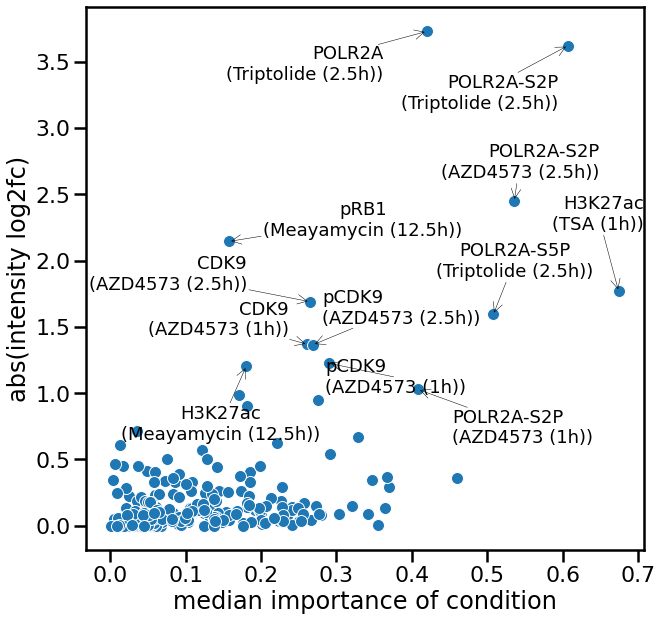

In [18]:
sns.set_context('poster')

# scatterplot comparing logfc and saliency
fig, ax = plt.subplots(1,1, figsize=(10,10))
df['abs_logfc'] = np.abs(df['logfc'])
sns.scatterplot(df, x='saliency', y='abs_logfc', ax=ax) # hue='perturbation')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

texts = []
for index, row in df[(df['abs_logfc'] > 1)].iterrows():
    x = row['saliency']
    y = row['abs_logfc']
    label = f'{index[1]}\n({index[0]})'
    texts.append(ax.text(x,y,label, fontsize=18))
    
adjust_text(texts, expand_points=(1.55, 1.7), arrowprops=dict(arrowstyle="->",  color='k',  lw=0.5), ax=ax)

ax.set_ylabel('abs(intensity log2fc)')
ax.set_xlabel('median importance of condition')

plt.savefig(fig_dir / 'saliency_vs_log2fc_latent.pdf', bbox_inches='tight', dpi=300)